In [77]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

import math

from sklearn import preprocessing

from scipy import stats
import scipy as sci

import random

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.spatial.distance import minkowski

from imblearn.under_sampling import *

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [78]:
#Mount  Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Colab\ Notebooks/ML\ Project2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/ML Project2'
/content/drive/My Drive/Colab Notebooks/ML Project2


# Import Dataset

In [79]:
df = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip')

In [80]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.drop(columns = 'Kmer', inplace = True)

In [81]:
y = df['relKa'].to_numpy()
x = df.loc[:, df.columns != 'relKa'].to_numpy()

# Split to 0 & 1

In [82]:
def split_importance(x,y,importance_class=0.7):
  """
  Split the samples into interesting ones and not interesting ones
  :param x: numpy.ndarray:the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param importance_class: float: the lower bound for the underepresented class
  """
  return x[y>=importance_class], y[y>=importance_class], x[y<importance_class], y[y<importance_class]

In [83]:
x_1,y_1,x_0,y_0 = split_importance(x,y)

# Train - Test Split

In [84]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train,x_1_test,y_1_train,y_1_test = train_test_split(x_1, y_1, test_size=0.30, random_state=42)
x_0_train,x_0_test,y_0_train,y_0_test = train_test_split(x_0, y_0, test_size=0.30, random_state=42)

x_train = np.concatenate((x_1_train,x_0_train))
y_train = np.concatenate((y_1_train,y_0_train))
x_test = np.concatenate((x_1_test,x_0_test))
y_test = np.concatenate((y_1_test,y_0_test))

# Remove Outliers

In [85]:
# Worse performances
def Anomaly_Detection_Isolation_Forests(x, change_split=True):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(y) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

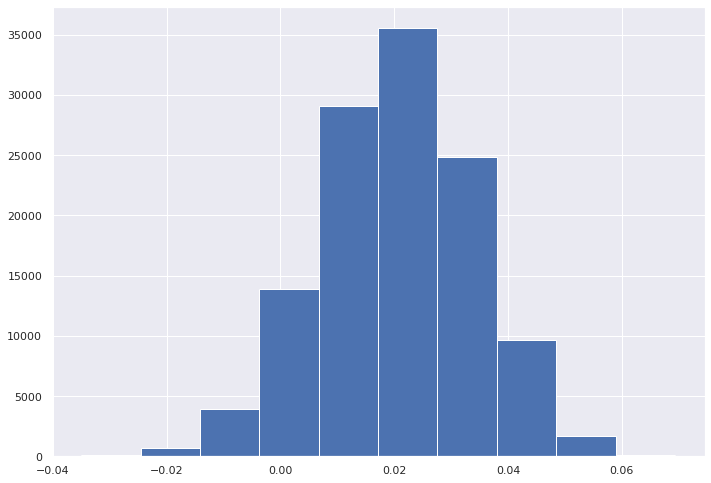

The indecision percentage around 0.02 is 0.3352659440383161
The percentage of outliers detected is 0.06591796057149557


In [86]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [87]:
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

# Feature Manipulation

In [88]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Boxcox Transformation

In [89]:
y_train, fitted_lambda= stats.boxcox(list(y_train),lmbda=None)
#print(fitted_lambda)
#print(stats.boxcox([0.7,1], fitted_lambda))
y_train = np.array(y_train)
print(fitted_lambda)

-1.0008549422054305


# Smote Sampling 

In [ ]:
#quantization function required for some score functions
def quantize(x,cuts=100):
  ranges = np.sort(np.unique(pd.cut(x,cuts)))
  for i in range(ranges.shape[0]):
    ranges_i = ranges[i]
    x[(x<=ranges_i.right)&(x>ranges_i.left)] = (ranges_i.left +ranges_i.right)/2
  return x

def quantize_features(x,cuts=100):
  return np.apply_along_axis(quantize,0,x,cuts)

#correlation scorers
def Spearman(i,j):
  ret,_ = spearmanr(i,j)
  return ret

def Correlation_Score(x,y):
  x = x.T
  score = [min([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

def Correlation_Score_Max(x,y):
  x = x.T
  score = [max([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)


In [90]:
def Furthest(x,z):
  """
  Returns the index of the sample in x which is furthest from all the samples in z
  :param x: numpy.ndarray: The array of the samples for which we seek to find the furthest
  :param z: numpy.ndarray: The array of the samples which we use as a point of reference
  :return: int: returns a single index corresponding to the furthest x
  """
  distances = []
  for i in range(x.shape[0]):
    distance = min([np.linalg.norm(j-x[i]) for j in z])
    distances.append(distance)
  return np.argmin(distances)

def PSU_undersampling(x,y,randomsize,xi,yi):
  C = np.mean(x,axis = 0)
  dist = np.linalg.norm(x-C,2,axis = 1)
  indices = dist.argsort()
  x = x[indices]
  y = y[indices]
  split_x = np.array_split(x,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],xi) for i in range(randomsize)]
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample,y_resample

def PSU_undersampling_reduced_dim(x,y,randomsize,xi,yi):
  feature_scores =  Fisher_Score(xi,x)
  indices = np.sort((-feature_scores).argsort()[:10])
  x_filtered = x[:,indices]
  x_i = xi[:,indices]
  C = np.mean(x_filtered,axis = 0)
  dist = np.linalg.norm(x_filtered-C,2,axis = 1)
  indices = dist.argsort()
  x_filtered = x_filtered[indices]
  y = y[indices]
  split_x = np.array_split(x_filtered,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],x_i) for i in range(randomsize)]
  split_x = np.array_split(x,randomsize)
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample,y_resample

def Fisher_Score(x_import,x_nimport):
  """
  Given two arrays of two classes this function calculates the Fischer_scores to 
  measure the significance for all features
  :param x_import: numpy.ndarray: the array containing the samples of one class
  :param x_nimport: numpy.ndarray: the array containing the samples of the other class
  :return: numpy.ndarray: returns an array containg the Fisher_Score for all features 
  """
  mean_import = np.mean(x_import,axis = 0)
  mean_nimport = np.mean(x_nimport,axis = 0)
  mean_dist = np.absolute(mean_import-mean_nimport)
  std_import = np.std(x_import,axis=0)
  std_nimport = np.std(x_nimport,axis=0)
  std_sum = std_import+std_nimport
  #return std_sum
  return np.divide(mean_dist,std_sum)

def calculate_distances(x,distance):
  """
  Calculates the distance between any two pairs of the set x using 
  the Minkowski distance of degree distance.
  :param x: numpy.ndarray: the vector for which we will calculate the distance 
                            between all of its elements 
  :param distance: float: the norm which should be used for the Minkowski distance
  :return: numpy.ndarray: returns the Minkowski distance with the specified norm 
                          between all pairs of elements in x 
  """
  dist = np.array([[minkowski(a1,a2,distance) for a2 in x] for a1 in x])
  np.fill_diagonal(dist,float('inf'))
  return dist

def random_sampler(x,y,randomsize,x1,x2):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x,y,neighbors,N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def smote_sf(x, y, undersample=0.5, oversample = 0.1, attribute_scorer=Fisher_Score, 
             attribute_number = 10, distance = float('inf'), kneighbors = 3,
             undersampling = random_sampler, importance_class = 0.7):
  """
  This function takes the complete input and produces a more balanced dataset based on the importance class
  :param x: numpy.ndarray: the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param undersample: float: the percentage of the dominant class that we want to keep
  :param oversample: float: the percentage of the dataset that the small class will be at the end
  :param attribute_scorer: function: a function which will be used to score the relevance of a feature
  :param attribute_number: int: the number of attributes to keep according to their score
  :param distance: float: the norm which should be used for the Minkowski distance
  :param kneighbors: int: the number of samples which should be considered for each point 
  :param undersampling: function: the function to use for the undersampling of the majority class
  :param importance_class: float: the lower bound for the underepresented class
  :return: returns 2 new feature vectors and 2 new label vectors containing 
            the data for the importance class and the data for the non importance 
            class and their labels. 
  """
  x_import = x[y>=importance_class]
  y_import = y[y>=importance_class]
  x_nimport = x[y<importance_class]
  y_nimport = y[y<importance_class]

  feature_scores =  attribute_scorer(x_import,x_nimport)
  #find the attribute_number highest coordinates of the feature_scores vector
  indices = np.sort((-feature_scores).argsort()[:attribute_number])
  x_import_filtered = x_import[:,indices]
  #x_nimport = x_nimport[:,indices]
  distances = calculate_distances(x_import_filtered,distance)
  #find the k lowest indices
  neighbors = np.array([ np.sort(d.argsort()[:(kneighbors)]) for d in distances])
  #undersampling for the majority class
  nimport_len = int(undersample*y_nimport.shape[0])
  x_nimport,y_nimport = undersampling(x_nimport,y_nimport,nimport_len,x_import,y_import)
  #Calculate the number of samples to be generated
  N = int(oversample*(y_nimport.shape[0]) - y_import.shape[0])
  #Generate N new samples
  new_samples_x,new_samples_y = generate_samples(x_import, y_import, neighbors, N)
  #merge the new samples of the minority class with its old samples
  x_import = np.concatenate((x_import,new_samples_x))
  y_import = np.concatenate((y_import,new_samples_y))

  x_ret = np.concatenate((x_import, x_nimport))
  y_ret = np.concatenate((y_import,y_nimport))
  return x_ret, y_ret

In [91]:
importance_boundary = stats.boxcox([0.7,1.],fitted_lambda)[0]
print(importance_boundary)

-0.4286406555284001


In [92]:
# try with the L1 norm
x_train1,y_train1 = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5, distance = 1.,undersampling = PSU_undersampling, importance_class = importance_boundary)
p = np.random.permutation(len(y_train1))
x_train1 = x_train1[p]
y_train1 = y_train1[p]

In [ ]:
# try with the L2 norm
x_train2,y_train2 = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5, distance = 2.,undersampling = PSU_undersampling,importance_class = importance_boundary)
p = np.random.permutation(len(y_train2))
x_train2 = x_train2[p]
y_train2 = y_train2[p]

In [ ]:
x_train,y_train = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5,undersampling = PSU_undersampling, importance_class = importance_boundary)

In [ ]:
p = np.random.permutation(len(y_train))
x_train = x_train[p]
y_train = y_train[p]

In [ ]:
print(x_train2.shape,y_train2.shape)

(14469, 318) (14469,)


# Metric

In [ ]:
def penalized_MSE_helper(y_true, y_pred):
    critical_indices = np.where(y_true >= 0.7)[0]
    print(critical_indices)
    print(y_true,y_pred)
    if(critical_indices.shape[0]==0 | critical_indices.shape[0]==y_true.shape[0]):
        return (1/2)*MSE(y_true, y_pred)
    else:
      critical_y = y_true[critical_indices]
      common_y = np.delete(y_true, critical_indices)
      critical_predictions = y_pred[critical_indices]
      common_predictions = np.delete(y_pred, critical_indices)
      return (1/2)*MSE(critical_y, critical_predictions)+ (1/2)*MSE(common_y, common_predictions)

In [ ]:
def penalized_MSE(y_true, y_pred,fitted_lambda=-1.0008549422054305):
  return penalized_MSE_helper(y_true,sci.special.inv_boxcox(y_pred, fitted_lambda))

def penalized_MSE_train(y_true, y_pred,fitted_lambda=-1.0008549422054305):
  return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))

# Training

In [ ]:
model = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model.fit(x_train, y_train,eval_metric=penalized_MSE_train)
predictions = model.predict(x_test)

[21:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
predictions = sci.special.inv_boxcox(predictions, fitted_lambda)

In [ ]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions))

the MSE for tuned model XGB Regressor is 0.0031429880988767694
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
[0.72502145 0.79381635 0.72175077 ... 0.1444491  0.23114848 0.15589872] [3.1627264 3.2895598 3.4726837 ... 1.1765703 1.1863221 1.1790321]
the weighted-MSE for tuned model XGB Regressor is 7.455629293165921


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


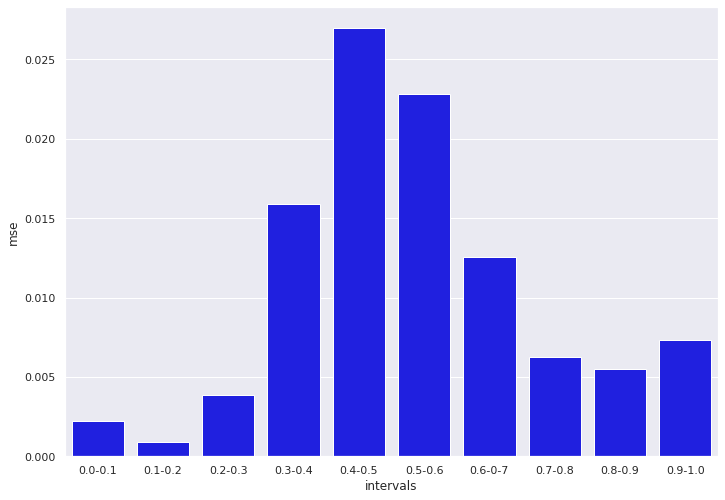

In [ ]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

In [93]:
model1 = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model1.fit(x_train1, y_train1,eval_metric=penalized_MSE_train)
predictions1 = model1.predict(x_test)

[01:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [94]:
predictions1 = sci.special.inv_boxcox(predictions1, fitted_lambda)

In [95]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions1))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions1))

the MSE for tuned model XGB Regressor is 0.0031350785692195356
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
[0.72502145 0.79381635 0.72175077 ... 0.1444491  0.23114848 0.15589872] [3.4115484 2.9616325 3.4388726 ... 1.1822995 1.19052   1.1739576]
the weighted-MSE for tuned model XGB Regressor is 7.894288044983811


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


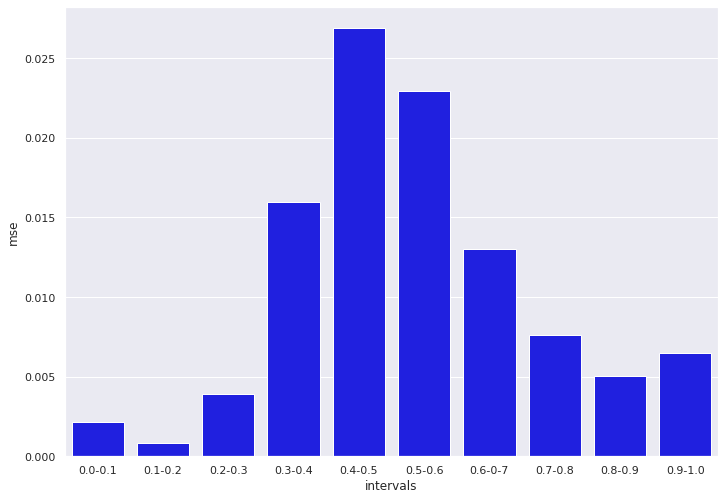

In [96]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions1[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

In [ ]:
model2 = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model2.fit(x_train2, y_train2,eval_metric=penalized_MSE_train)
predictions2 = model2.predict(x_test)

[21:22:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
predictions2 = sci.special.inv_boxcox(predictions2, fitted_lambda)

In [ ]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions2))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions2))

the MSE for tuned model XGB Regressor is 0.003156358370571745
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
[0.72502145 0.79381635 0.72175077 ... 0.1444491  0.23114848 0.15589872] [3.3578894 3.7134748 3.1650443 ... 1.1831207 1.186374  1.1816555]
the weighted-MSE for tuned model XGB Regressor is 7.3848966289874465


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


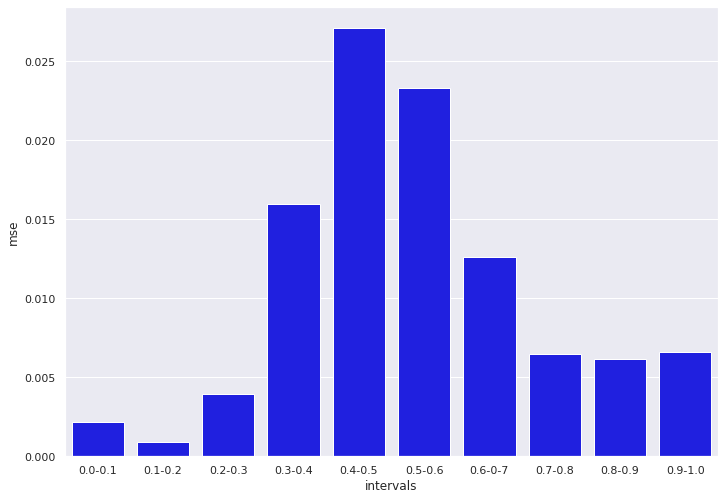

In [ ]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions2[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

In [ ]:
params = { 'max_depth': [5, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.5, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
           'n_estimators': [100,500,1000]
            }

score = make_scorer(penalized_MSE_train, greater_is_better=False)
model = XGBRegressor(tree_method='gpu_hist',seed = 20)
clf = RandomizedSearchCV(estimator = model,
                         param_distributions = params,
                         scoring = score,
                         n_iter=10,
                         verbose=10)
clf.fit(x_train, y_train,eval_metric = penalized_MSE_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bylevel=0.7, colsample_bytree=0.7999999999999999, learning_rate=0.01, max_depth=15, n_estimators=500, subsample=0.7
[23:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[   1    8   11   17   19   20   23   33   34   36   39   43   47   52
   55   65   67   70   74   76   78   80   85   87   89   97   98  102
  108  109  111  114  117  119  121  123  124  128  130  135  138  140
  149  162  169  171  174  175  177  180  188  189  190  192  195  202
  212  224  227  234  235  237  238  242  243  245  247  248  251  252
  257  262  264  267  271  274  275  277  279  280  287  292  297  304
  306  307  314  319  327  332  334  336  340  345  346  347  350  352
  354  358  368  375  379  381  385  388  390  391  394  395  402  404
  412  418  422  423  424  428  430  438  443  447  450  459  468  477
  479  484  485  486  488 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-32-fc5a6eefbb96>", line 5, in penalized_MSE_train
    return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))
  File "<ipython-input-31-ae3c46e3511d>", line 11, in penalized_MSE_helper
    return (1/2)*MSE(critical_y, cr

[   3    5    7   12   14   20   22   25   27   31   32   33   43   47
   51   62   64   69   70   71   74   76   88   89  109  111  113  115
  125  133  137  141  143  145  148  156  159  174  175  176  180  190
  191  195  199  200  203  205  207  209  210  212  213  215  220  227
  231  238  252  258  262  268  269  272  310  311  314  315  332  334
  356  361  362  363  364  367  368  369  371  373  377  380  384  385
  390  399  403  407  409  410  417  429  431  435  444  449  464  465
  466  467  470  474  475  480  489  490  492  493  498  499  501  505
  509  512  513  517  518  521  524  529  533  534  537  539  541  545
  549  550  558  560  564  573  574  577  580  584  585  586  587  594
  598  605  606  612  624  627  628  630  642  647  649  651  663  665
  679  680  691  696  701  710  711  716  727  731  733  736  744  750
  751  759  760  763  765  771  773  776  780  789  794  806  809  812
  814  820  821  833  838  844  855  859  866  868  884  890  894  902
  905 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-32-fc5a6eefbb96>", line 5, in penalized_MSE_train
    return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))
  File "<ipython-input-31-ae3c46e3511d>", line 11, in penalized_MSE_helper
    return (1/2)*MSE(critical_y, cr

[   4   11   30   35   36   37   41   54   63   66   69   76   87   97
   98  102  106  130  131  133  134  142  148  149  159  161  165  176
  178  187  190  191  194  201  202  206  224  226  227  232  238  246
  248  250  256  259  261  264  270  271  274  278  279  287  288  290
  303  304  307  313  314  316  318  322  324  327  334  335  339  346
  347  349  358  367  369  373  374  375  376  377  378  390  391  393
  394  397  398  411  420  421  423  428  429  435  442  443  448  450
  457  461  464  465  467  469  474  493  497  499  500  501  503  520
  529  530  545  547  553  561  562  567  569  570  573  586  592  597
  598  599  603  604  605  611  625  629  630  633  636  640  645  654
  658  662  670  675  678  686  690  692  697  699  702  707  710  718
  719  725  731  732  733  738  745  746  752  777  782  784  788  790
  793  794  797  798  800  802  804  813  824  825  826  832  836  852
  856  859  861  864  868  871  878  885  889  891  896  904  911  913
  917 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-32-fc5a6eefbb96>", line 5, in penalized_MSE_train
    return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))
  File "<ipython-input-31-ae3c46e3511d>", line 11, in penalized_MSE_helper
    return (1/2)*MSE(critical_y, cr

[   3    5    7   12   14   20   22   25   27   31   32   33   43   47
   51   62   64   69   70   71   74   76   88   89  109  111  113  115
  125  133  137  141  143  145  148  156  159  174  175  176  180  190
  191  195  199  200  203  205  207  209  210  212  213  215  220  227
  231  238  252  258  262  268  269  272  310  311  314  315  332  334
  356  361  362  363  364  367  368  369  371  373  377  380  384  385
  390  399  403  407  409  410  417  429  431  435  444  449  464  465
  466  467  470  474  475  480  489  490  492  493  498  499  501  505
  509  512  513  517  518  521  524  529  533  534  537  539  541  545
  549  550  558  560  564  573  574  577  580  584  585  586  587  594
  598  605  606  612  624  627  628  630  642  647  649  651  663  665
  679  680  691  696  701  710  711  716  727  731  733  736  744  750
  751  759  760  763  765  771  773  776  780  789  794  806  809  812
  814  820  821  833  838  844  855  859  866  868  884  890  894  902
  905 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-32-fc5a6eefbb96>", line 5, in penalized_MSE_train
    return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))
  File "<ipython-input-31-ae3c46e3511d>", line 11, in penalized_MSE_helper
    return (1/2)*MSE(critical_y, cr

[   5   11   14   25   27   37   41   42   51   52   55   56   59   60
   76   81   83   90   96  100  108  109  114  116  119  124  128  135
  137  142  145  147  150  157  164  167  170  178  185  190  192  194
  198  202  211  214  222  223  237  238  243  246  252  255  258  260
  261  268  270  271  276  283  286  288  294  302  318  322  326  331
  335  336  348  350  351  353  354  370  375  380  382  383  390  393
  403  404  406  407  409  421  424  433  438  440  442  455  463  473
  476  478  479  481  482  487  489  497  499  502  504  509  510  516
  517  521  529  533  536  540  541  546  552  556  557  560  566  572
  575  578  579  581  595  602  603  612  614  617  618  622  626  629
  639  642  644  657  660  666  668  673  675  676  688  689  690  692
  695  696  697  703  705  715  717  718  719  728  730  733  740  747
  755  759  761  764  765  773  776  779  782  784  786  794  797  799
  800  810  811  816  822  830  831  833  836  855  858  864  868  879
  880 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-32-fc5a6eefbb96>", line 5, in penalized_MSE_train
    return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))
  File "<ipython-input-31-ae3c46e3511d>", line 11, in penalized_MSE_helper
    return (1/2)*MSE(critical_y, cr

RandomizedSearchCV(estimator=XGBRegressor(seed=20, tree_method='gpu_hist'),
                   param_distributions={'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.5],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring=make_scorer(penalized_MSE_train, greater_is_better=False),
                   verbose=10)

In [ ]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions))

Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7}
Lowest RMSE:  0.04728283976535687
the MSE for tuned model XGB Regressor is 0.002565872901295706
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
the weighted-MSE for tuned model XGB Regressor is 7.521273302145339


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


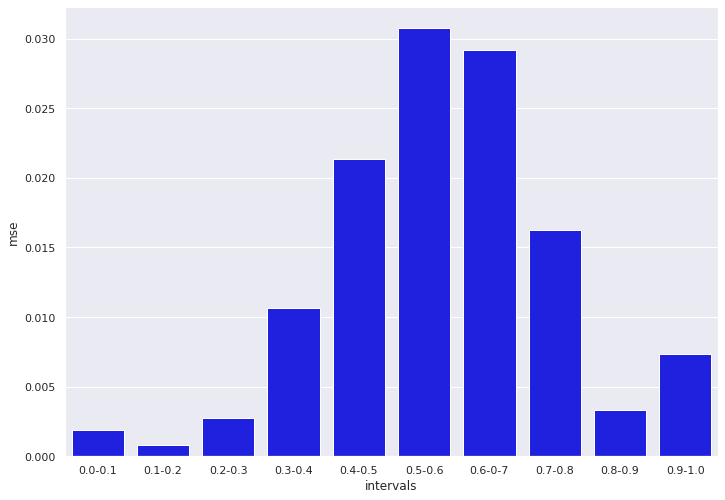

In [ ]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()